# Topic & Sentiment Analysis of tweets with #donaldtrump during 2020 elections

## Introduction

This project investigates the main **themes (topics)** and **emotional tone (sentiment)** in tweets related to Donald Trump (US 2020 election period).  

The workflow follows a reproducible text-mining pipeline:   
**data inspection → preprocessing → topic modelling → sentiment analysis (VADER + supervised) → joint topic–sentiment analysis**.  

The output is both qualitative (interpretable topics + example tweets) and quantitative (sentiment distributions and topic-level sentiment composition).

### Dataset

This project uses a dataset of tweets related to Donald Trump collected during the 2020 U.S. election period (from Kaggle). Each record represents a single tweet and includes the tweet text, information about when it was posted, basic engagement signals (such as likes and retweets), and some optional user-provided metadata (including self-declared location fields). We downoladed it via Kaggle API, which is available in `API.ipynb` notebook.

A key characteristic of this dataset is that it contains multiple languages. For methods like topic modelling and lexicon-based sentiment analysis, language differences can strongly influence results. For that reason, the analysis will focus on English-language tweets. To order this we used `lid.176 model` - whole transformtion is available in the `LANGUAGE_DETECTION.ipynb` notebook

### Goal

The goal of this project is to discover the main themes of discussion in tweets about Donald Trump and then examine how emotional tone differs across these themes. In other words, we first ask what people talk about, and then we check how they feel when discussing different issues.

### Research questions

1.	What are the dominant themes present in Trump-related tweets? (topic analysis)
2.	What is the overall balance of positive, neutral, and negative tone in the dataset? (sentiment analysis)
3.	Which themes tend to be most positive or most negative? (joint topic x sentiment analysis)


## Data overview

#### Installing all needed packages

In [151]:
import re
import string
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Text / NLP
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Topic modeling
from sklearn.decomposition import NMF

# Model selection + metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB


from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve
)

from wordcloud import WordCloud

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# reproducibility seed
SEED = 420
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
# Load the file with only English tweets
df = pd.read_csv("data/hashtag_donaldtrump_en.csv", engine='python')

df.head(5)

#### Basic size + column check

In [4]:
print("Rows:", len(df))
print("Columns:", df.shape[1])
print("\nColumns list:\n", df.columns.tolist())

Rows: 542322
Columns: 23

Columns list:
 ['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source', 'user_id', 'user_name', 'user_screen_name', 'user_description', 'user_join_date', 'user_followers_count', 'user_location', 'lat', 'long', 'city', 'country', 'continent', 'state', 'state_code', 'collected_at', 'lang_pred', 'lang_prob']


In [5]:
wanted = [
    "tweet_id", "created_at", 
    "tweet", "country",
    "retweet_count", "likes", "user_id", "user_followers_count"
]

keep = [c for c in wanted if c in df.columns]
df_small = df[keep].copy()

# Unify text column name (prefer 'tweet' if available)
if "tweet" not in df_small.columns and "text" in df_small.columns:
    df_small.rename(columns={"text": "tweet"}, inplace=True)

df_small.head(5)

,tweet_id,created_at,tweet,country,retweet_count,likes,user_id,user_followers_count
0,1.316529e+18,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",United States of America,1.0,2.0,8.436472e+06,1185.0
1,1.316529e+18,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,NaN,0.0,0.0,8.283556e+17,32.0
2,1.316529e+18,2020-10-15 00:00:17,@CLady62 Her 15 minutes were over long time ag...,United States of America,0.0,2.0,1.138416e+09,2363.0
3,1.316529e+18,2020-10-15 00:00:17,@richardmarx Glad u got out of the house! DICK...,NaN,0.0,0.0,7.674018e+17,75.0
4,1.316529e+18,2020-10-15 00:00:18,@DeeviousDenise @realDonaldTrump @nypost There...,United States of America,0.0,0.0,9.007611e+17,766.0


In [6]:
# Missing text
missing_text = df_small["tweet"].isna().mean() * 100
print(f"Missing tweet text: {missing_text:.2f}%")

# Duplicates by tweet content (ignoring missing)
dup_mask = df_small["tweet"].notna() & df_small["tweet"].duplicated(keep="first")
dup_pct = dup_mask.mean() * 100
print(f"Duplicate tweets by identical content: {dup_pct:.2f}%")

# removing duplicates
df_nodup = df_small.loc[~dup_mask].copy()
print("Rows after duplicate removal:", len(df_nodup))

Missing tweet text: 0.00%
Duplicate tweets by identical content: 1.27%
Rows after duplicate removal: 535426


In [7]:
rt_mask = df_nodup["tweet"].fillna("").str.startswith("RT @")
rt_pct = rt_mask.mean() * 100

print(f"Retweets: {rt_pct:.2f}%")
print(f"Original tweets: {100-rt_pct:.2f}%")

# Optional (recommended for cleaner topics):
df_work = df_nodup.loc[~rt_mask].copy()
print("Rows after removing retweets:", len(df_work))

Retweets: 0.01%
Original tweets: 99.99%
Rows after removing retweets: 535347


#### Final numbers

In [8]:
summary = {
    "rows_loaded": len(df),
    "rows_after_select": len(df_small),
    "missing_text_%": round(missing_text, 2),
    "duplicates_%": round(dup_pct, 2),
    "retweets_%": round(rt_pct, 2),
    "final_rows_for_modeling": len(df_work)
}
summary

{'rows_loaded': 542322,
 'rows_after_select': 542322,
 'missing_text_%': 0.0,
 'duplicates_%': 1.27,
 'retweets_%': 0.01,
 'final_rows_for_modeling': 535347}

##### Data overview summary
In this section we validated basic dataset quality before modelling:
- dataset size and available columns,
- missingness in the tweet text,
- duplicates / retweets handling (to avoid over-counting repeated content),
- final row counts after filtering steps.

This step ensures that later modelling results are not driven by trivial data issues (missing text, heavy duplication, extreme noise).

## Preprocessing

#### Basic text clearing

In [9]:
df_prep = df_work.copy()

# Make sure it's string
s = df_prep["tweet"].fillna("").astype(str)

# vectorized cleaning (to make it faster on 0.5mln rows)
s = s.str.replace(r"http\S+|www\.\S+", " ", regex=True)     # URLs
s = s.str.replace(r"@\w+", " ", regex=True)                # mentions
s = s.str.replace(r"\bRT\b", " ", regex=True)              # RT marker
s = s.str.replace(r"#", "", regex=True)                    # keep hashtag words, drop '#'
s = s.str.lower()                                          # lowercase
s = s.str.replace(r"[^a-z\s']", " ", regex=True)           # keep letters/spaces/apostrophes
s = s.str.replace(r"\s+", " ", regex=True).str.strip()     # normalize spaces

df_prep["text_clean"] = s

df_prep[["tweet", "text_clean"]].head(5)

,tweet,text_clean
0,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...
1,2 hours since last tweet from #Trump! Maybe he...,hours since last tweet from trump maybe he is ...
2,@CLady62 Her 15 minutes were over long time ag...,her minutes were over long time ago omarosa ne...
3,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dick trump
4,@DeeviousDenise @realDonaldTrump @nypost There...,there won t be many of them unless you all hav...


#### Removing very short tweets (for better topic modelling)

In [10]:
df_prep["n_chars"] = df_prep["text_clean"].str.len()
df_prep["n_words"] = df_prep["text_clean"].str.split().str.len()

print("Before:", len(df_prep))
df_prep = df_prep[df_prep["n_words"] >= 3].copy()
print("After removing very short texts:", len(df_prep))

Before: 535347
After removing very short texts: 534344


#### Dealing with stopwords

In [146]:
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

# Add Twitter/politics-specific "junk" words you don't want as topics
extra_stop = {
    "amp", "im", "dont", "didnt", "doesnt", "cant", "wont",
    "https", "tco", "co", "u", "like", "looks",
    "trump", "donaldtrump"   # for 100% it would be number 1, we are removing it to get more interesting topics
}
stop_words = stop_words.union(extra_stop)

stop_words_list = list(stop_words)
print("Stopwords size:", len(stop_words_list))

Stopwords size: 213


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/czarek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Creating 2 versions of final dataset

- For topic modelling: stronger cleaning is correct way
- For sentiment: keeping lighter version would be more beneficial

In [147]:
df_prep["text_for_topics"] = df_prep["text_clean"]
df_prep["text_for_sentiment"] = df_prep["tweet"].fillna("").astype(str)  # raw-ish for VADER later

df_prep[["text_for_topics", "text_for_sentiment"]].head(3)

,text_for_topics,text_for_sentiment
0,trump as a student i used to hear for years fo...,"#Trump: As a student I used to hear for years,..."
1,hours since last tweet from trump maybe he is ...,2 hours since last tweet from #Trump! Maybe he...
2,her minutes were over long time ago omarosa ne...,@CLady62 Her 15 minutes were over long time ag...


#### Preprocessing summary
Preprocessing prepares tweets for reliable topic modelling and sentiment:
- basic cleaning: URLs, mentions, hashtags formatting, lowercasing, whitespace normalization,
- removal of very short tweets (to reduce topic-model noise),
- stopword handling (generic + task-specific terms),
- creation of two parallel text variants:
  - `text_for_topics` for topic modelling (more aggressively cleaned)
  - `text_for_sentiment` for sentiment scoring (closer to original phrasing)

This split reflects the typical NLP practice: topic models benefit from stronger normalization, while sentiment benefits from preserving surface form.

#### Simple EDA before topci

In [148]:
# Use df_topics (sample) for speed, or df_prep for full
tmp = df_prep.copy()

tmp["n_words"] = tmp["text_for_topics"].str.split().str.len()
tmp["n_chars"] = tmp["text_for_topics"].str.len()

tmp[["n_words", "n_chars"]].describe()

,n_words,n_chars
count,534344.000000,534344.000000
mean,25.489001,151.385476
std,12.938555,72.881908
min,3.000000,10.000000
25%,15.000000,89.000000
50%,24.000000,146.000000
75%,36.000000,219.000000
max,68.000000,291.000000


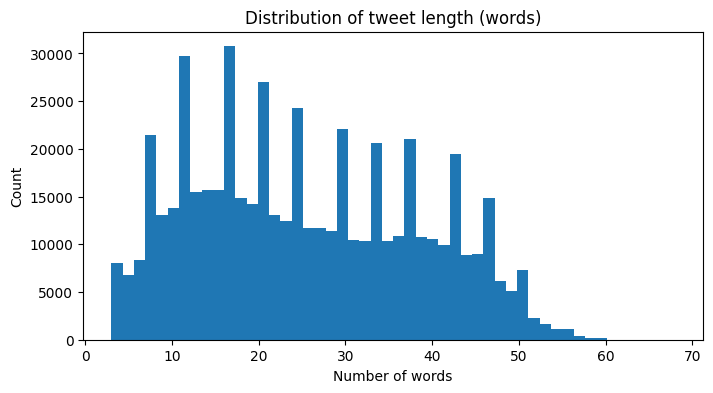

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(tmp["n_words"], bins=50)
plt.title("Distribution of tweet length (words)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

#### Most common words (unigrams)

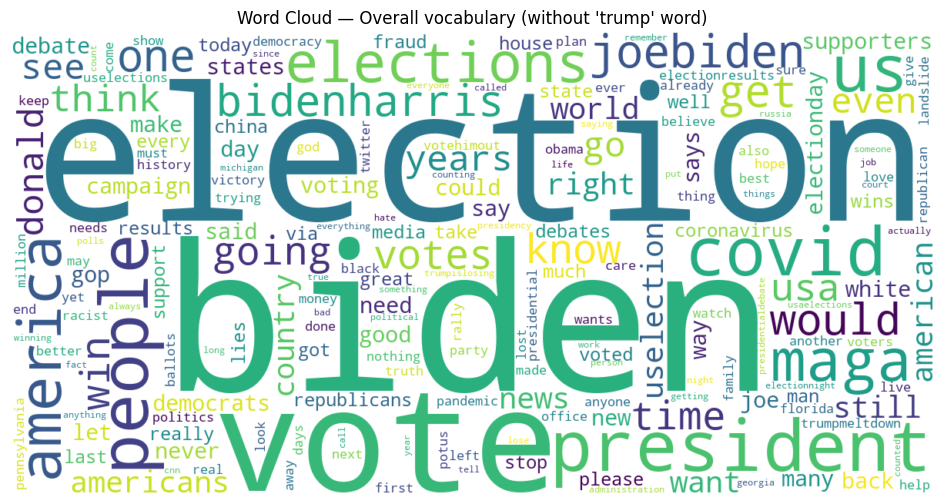

,word,count
1473,biden,124067
5045,election,103659
17121,vote,70379
11949,president,46782
11349,people,41991
3474,covid,41815
16830,us,38163
501,america,32997
9369,maga,32324
5061,elections,29414


In [149]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from wordcloud import WordCloud


cv = CountVectorizer(
    stop_words=stop_words_list,   # from your preprocessing
    min_df=20                     # adjust: 10/20/50 depending on dataset size
)

X = cv.fit_transform(df_prep["text_for_topics"])

word_counts = X.sum(axis=0).A1
vocab = cv.get_feature_names_out()
freq = dict(zip(vocab, word_counts))  # word -> count

wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200,
    collocations=False   # important: prevents "new york" style artifacts if you don't want them
).generate_from_frequencies(freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud — Overall vocabulary (without 'trump' word)")
plt.show()

# (optional) keep your top words table too
top_words = (
    pd.DataFrame({"word": vocab, "count": word_counts})
      .sort_values("count", ascending=False)
      .head(20)
)
top_words

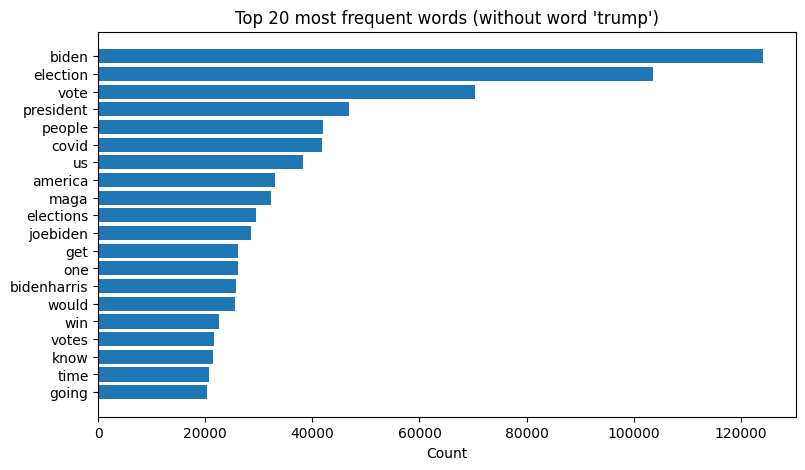

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9,5))
plt.barh(top_words["word"][::-1], top_words["count"][::-1])
plt.title("Top 20 most frequent words (without word 'trump')")
plt.xlabel("Count")
plt.show()

#### Most common bigrams

In [17]:
cv2 = CountVectorizer(
    stop_words=stop_words_list,
    ngram_range=(2,2),
    min_df=20
)

X2 = cv2.fit_transform(df_prep["text_for_topics"])

bigram_counts = X2.sum(axis=0).A1
bigrams = cv2.get_feature_names_out()

top_bigrams = (
    pd.DataFrame({"bigram": bigrams, "count": bigram_counts})
      .sort_values("count", ascending=False)
      .head(20)
)

top_bigrams

,bigram,count
13032,joe biden,9095
29910,white house,7530
7591,election biden,5544
7896,election results,5532
27177,united states,4197
2310,biden election,3662
28059,vote biden,3576
28365,vote vote,3272
854,american people,3159
7649,election day,3039


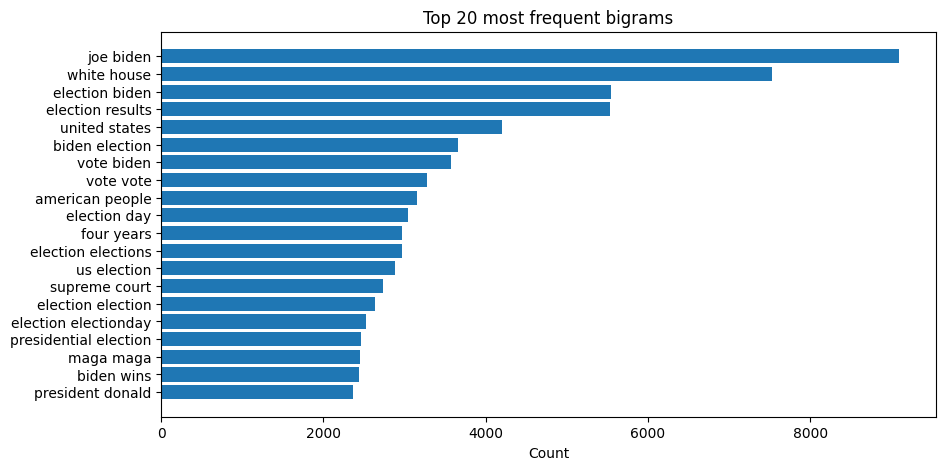

In [18]:
plt.figure(figsize=(10,5))
plt.barh(top_bigrams["bigram"][::-1], top_bigrams["count"][::-1])
plt.title("Top 20 most frequent bigrams")
plt.xlabel("Count")
plt.show()

## Quick EDA summary
Before modelling, we inspect the most frequent:
- unigrams (single words)
- bigrams (two-word phrases)
- and created word cloud

This helps verify that preprocessing worked correctly and gives intuition about dominant vocabulary and recurring phrases that may later form coherent topics.

## Topic modelling

In [19]:
text_col = "text_for_topics" if "text_for_topics" in df_prep.columns else "text_clean"
texts = df_prep[text_col].fillna("").astype(str)

print("Rows for topic modelling:", len(texts))

Rows for topic modelling: 534344


#### TF-IDF vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words=stop_words_list,
    min_df=50,          # increase if memory is an issue (e.g., 100)
    max_df=0.90,
    ngram_range=(1, 2)
)

X = tfidf.fit_transform(texts)
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (534344, 19971)


#### Fitting NMF

In [21]:
from sklearn.decomposition import NMF

K = 8  # number of topics
# I've been trying with numerous combinations but that number gives the best results

nmf = NMF(
    n_components=K,
    random_state=420,
    init="nndsvda",
    max_iter=400
)

W = nmf.fit_transform(X)
H = nmf.components_

print("W shape:", W.shape, "| H shape:", H.shape)

W shape: (534344, 8) | H shape: (8, 19971)


#### Top words per topic

In [22]:
feature_names = tfidf.get_feature_names_out()

def print_top_words(model, feature_names, n_top_words=12):
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[::-1][:n_top_words]
        top_terms = [feature_names[i] for i in top_idx]
        print(f"Topic {topic_idx}: " + ", ".join(top_terms))

print_top_words(nmf, feature_names, n_top_words=10)

Topic 0: election, elections, results, election results, electionday, joebiden, election election, win, election biden, election elections
Topic 1: vote, vote vote, vote biden, bidenharris, votehimout, vote election, election vote, biden vote, voteearly, america
Topic 2: people, one, get, would, know, america, going, time, think, years
Topic 3: biden, joe, joe biden, debate, elections, uselection, votes, debates, win, election biden
Topic 4: president, donald, joebiden, us, states, united, united states, america, president donald, mr
Topic 5: maga, maga maga, kag, landslidevictory, maga landslidevictory, maga kag, gop, landslide, maga election, america
Topic 6: covid, coronavirus, covid covid, cases, covid coronavirus, pandemic, deaths, gop, americans, virus
Topic 7: white, house, white house, leave, leave white, donald, house biden, whitehouse, trumpmeltdown, house election


#### Assigning topic to every tweet

In [23]:
df_prep["topic_id"] = np.argmax(W, axis=1)
df_prep["topic_strength"] = np.max(W, axis=1)

df_prep[["tweet", text_col, "topic_id", "topic_strength"]].head(5)

,tweet,text_for_topics,topic_id,topic_strength
0,"#Trump: As a student I used to hear for years,...",trump as a student i used to hear for years fo...,2,0.024834
1,2 hours since last tweet from #Trump! Maybe he...,hours since last tweet from trump maybe he is ...,2,0.005649
2,@CLady62 Her 15 minutes were over long time ag...,her minutes were over long time ago omarosa ne...,2,0.011354
3,@richardmarx Glad u got out of the house! DICK...,glad u got out of the house dick trump,7,0.039809
4,@DeeviousDenise @realDonaldTrump @nypost There...,there won t be many of them unless you all hav...,4,0.022738


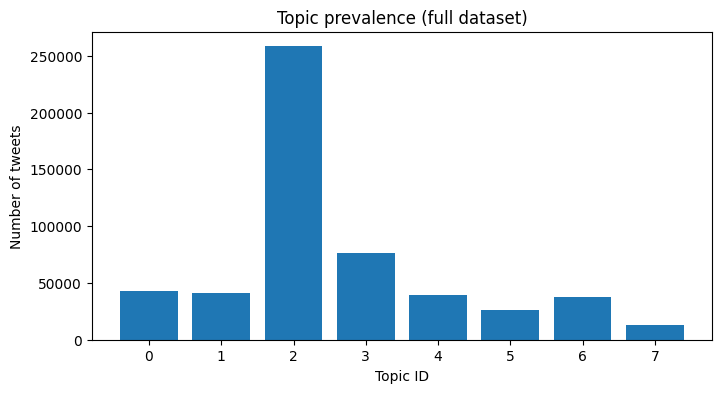

topic_id
0     42626
1     41329
2    258193
3     76267
4     39245
5     26491
6     37367
7     12826
Name: count, dtype: int64

In [111]:
import matplotlib.pyplot as plt

topic_counts = df_prep["topic_id"].value_counts().sort_index()

plt.figure(figsize=(8,4))
plt.bar(topic_counts.index.astype(str), topic_counts.values)
plt.title("Topic prevalence (full dataset)")
plt.xlabel("Topic ID")
plt.ylabel("Number of tweets")
plt.show()

topic_counts

#### Example tweets per topic

In [113]:
for t in range(K):
    print("\n" + "="*60)
    print(f"Topic {t} — examples")
    examples = df_prep[df_prep["topic_id"] == t].sort_values("topic_strength", ascending=False).head(3)
    for _, row in examples.iterrows():
        print("-", row["tweet"])


Topic 0 — examples
- And they're off … #Trump #2020Election https://t.co/7S7ptcnc8k https://t.co/Sozi9uWdO5
- What will it be for #Trump? #Election2020
- By  by  #Trump .😎

#Election2020 https://t.co/a54rGyFcel

Topic 1 — examples
- #IndianAmericans  vote for #DonaldTrump.
- Vote #Trump #ForwardWithTrumpNotBackWithBiden - https://t.co/B6bv0G151w
- Don't vote for #Trump #Trump2020 https://t.co/VhNUSR1n4N

Topic 2 — examples
- What does #Trump have on all of these people? https://t.co/pYZKlVF4DJ
- @ASimplePatriot @udtflea BUT BUT BUT #TRUMP .. lololol fn people.. #LiberalismIsASickness #FindACure #TDSISREAL
- Your people #trump tardy https://t.co/UA3m56HghL

Topic 3 — examples
- https://t.co/JK9YSwMUrC #SaintAmour #Trump #Biden
- #Biden chowing #Trump... https://t.co/2uYELzTMSa
- #dgl #lod #sciencefiction #tictacdough #tacticprick #Biden2020 #Trump https://t.co/I8cq2as8GX

Topic 4 — examples
- We're all with you, president ✊🇺🇸
#Trump https://t.co/DH4PUPlIws
- @RaychelTania #donaldTrump 

#### Topic modelling summary
We applied topic modelling using a standard pipeline:
- TF-IDF vectorization (to weight informative terms higher than common terms),
- NMF topic model to extract K topics as interpretable word-weight components.

Outputs produced:
- top words per topic (interpretability),
- per-tweet topic assignment (`topic_id`) and topic strength (`topic_strength`),
- example tweets per topic to validate semantic coherence.

The chosen K is justified pragmatically by interpretability: topics are distinct enough to label and illustrate with examples.

## Sentiment modelling (using VADER)

Install dependencies with `uv` (see README), then restart the kernel.


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### Computing VADER scores on raw tweet texts

In [28]:
analyzer = SentimentIntensityAnalyzer()

df_sa = df_prep.copy()

df_sa["compound"] = df_sa["tweet"].fillna("").astype(str).apply(lambda x: analyzer.polarity_scores(x)["compound"])
df_sa["pos"] = df_sa["tweet"].fillna("").astype(str).apply(lambda x: analyzer.polarity_scores(x)["pos"])
df_sa["neu"] = df_sa["tweet"].fillna("").astype(str).apply(lambda x: analyzer.polarity_scores(x)["neu"])
df_sa["neg"] = df_sa["tweet"].fillna("").astype(str).apply(lambda x: analyzer.polarity_scores(x)["neg"])

df_sa[["tweet", "compound", "pos", "neu", "neg"]].head(5)

,tweet,compound,pos,neu,neg
0,"#Trump: As a student I used to hear for years,...",0.5905,0.066,0.934,0.000
1,2 hours since last tweet from #Trump! Maybe he...,0.0000,0.000,1.000,0.000
2,@CLady62 Her 15 minutes were over long time ag...,-0.4912,0.000,0.878,0.122
3,@richardmarx Glad u got out of the house! DICK...,0.5962,0.217,0.783,0.000
4,@DeeviousDenise @realDonaldTrump @nypost There...,-0.2617,0.056,0.866,0.078


In [29]:
def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df_sa["sentiment"] = df_sa["compound"].apply(vader_label)

df_sa["sentiment"].value_counts()

sentiment
positive    219906
negative    211734
neutral     102704
Name: count, dtype: int64

#### Overall sentiment distribution

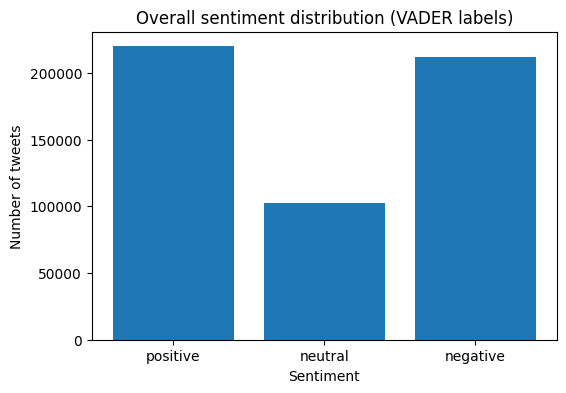

In [30]:
sent_counts = df_sa["sentiment"].value_counts()

order = ["positive", "neutral", "negative"]
sent_counts = sent_counts.reindex(order).fillna(0)

plt.figure(figsize=(6,4))
plt.bar(sent_counts.index, sent_counts.values)
plt.title("Overall sentiment distribution (VADER labels)")
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.show()

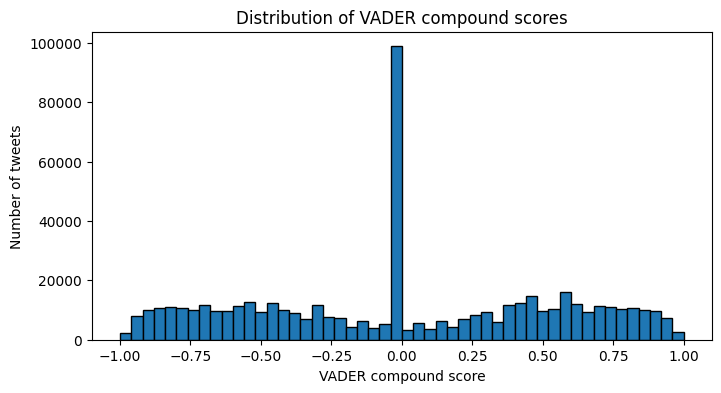

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(df_sa["compound"], bins=50, edgecolor="black")
plt.title("Distribution of VADER compound scores")
plt.xlabel("VADER compound score")
plt.ylabel("Number of tweets")
plt.show()

In [32]:
df_sa.head()

,tweet_id,created_at,tweet,country,retweet_count,likes,user_id,user_followers_count,text_clean,n_chars,n_words,text_for_topics,text_for_sentiment,topic_id,topic_strength,compound,pos,neu,neg,sentiment
0,1.316529e+18,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",United States of America,1.0,2.0,8.436472e+06,1185.0,trump as a student i used to hear for years fo...,237,53,trump as a student i used to hear for years fo...,"#Trump: As a student I used to hear for years,...",2,0.024834,0.5905,0.066,0.934,0.000,positive
1,1.316529e+18,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,NaN,0.0,0.0,8.283556e+17,32.0,hours since last tweet from trump maybe he is ...,73,13,hours since last tweet from trump maybe he is ...,2 hours since last tweet from #Trump! Maybe he...,2,0.005649,0.0000,0.000,1.000,0.000,neutral
2,1.316529e+18,2020-10-15 00:00:17,@CLady62 Her 15 minutes were over long time ag...,United States of America,0.0,2.0,1.138416e+09,2363.0,her minutes were over long time ago omarosa ne...,129,22,her minutes were over long time ago omarosa ne...,@CLady62 Her 15 minutes were over long time ag...,2,0.011354,-0.4912,0.000,0.878,0.122,negative
3,1.316529e+18,2020-10-15 00:00:17,@richardmarx Glad u got out of the house! DICK...,NaN,0.0,0.0,7.674018e+17,75.0,glad u got out of the house dick trump,38,9,glad u got out of the house dick trump,@richardmarx Glad u got out of the house! DICK...,7,0.039809,0.5962,0.217,0.783,0.000,positive
4,1.316529e+18,2020-10-15 00:00:18,@DeeviousDenise @realDonaldTrump @nypost There...,United States of America,0.0,0.0,9.007611e+17,766.0,there won t be many of them unless you all hav...,216,42,there won t be many of them unless you all hav...,@DeeviousDenise @realDonaldTrump @nypost There...,4,0.022738,-0.2617,0.056,0.866,0.078,negative


#### Sentiment analysis (VADER) summary
As a dictionary-based baseline, we used VADER to compute:
- a continuous sentiment score (`compound`)
- a 3-class label (`negative`, `neutral`, `positive`) using standard thresholding logic.

We present:
- overall sentiment distribution,
- examples and sanity checks to ensure labels match intuitive polarity in short tweets.

## Supervised sentiment

In [33]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, roc_auc_score, average_precision_score
)

#### Selecting proper text column

In [34]:
df_base = df_sa.copy()

# For supervised model we prefer cleaned text (less noise)
text_col = "text_clean"

# ensure text is string
df_base[text_col] = df_base[text_col].astype(str).fillna("").str.strip()

#### Creating weak labels from high-confidence VADER scores

we are taking only tweets with extreme VADER values to "feed" our models with the best training data possible

In [35]:
POS_TH = 0.6
NEG_TH = -0.6

df_sup = df_base[[text_col, "compound"]].dropna().copy()
df_sup = df_sup[df_sup[text_col].str.len() > 0].copy()

df_sup["y"] = np.where(df_sup["compound"] >= POS_TH, 1,
                       np.where(df_sup["compound"] <= NEG_TH, 0, np.nan))
df_sup = df_sup.dropna(subset=["y"]).copy()
df_sup["y"] = df_sup["y"].astype(int)

print("Weak-label dataset size:", len(df_sup))
print(df_sup["y"].value_counts().rename({0: "NEG", 1: "POS"}))

Weak-label dataset size: 188509
y
POS    94818
NEG    93691
Name: count, dtype: int64


#### Dividing into train/test parts

In [36]:
X = df_sup[text_col].values
y = df_sup["y"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=420, stratify=y
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=420)

### Model 1: TF-IDF + Logistic Regression

In [37]:
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", LogisticRegression(max_iter=2000))
])

param_grid_lr = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.8, 0.95],
    "tfidf__sublinear_tf": [True],
    "clf__C": [0.1, 1.0, 3.0],
    "clf__class_weight": [None, "balanced"]
}

gs_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs_lr.fit(X_train, y_train)
best_lr = gs_lr.best_estimator_

print("\nBest LR params:", gs_lr.best_params_)
print("Best LR CV F1:", gs_lr.best_score_)

lr_pred = best_lr.predict(X_test)
lr_proba = best_lr.predict_proba(X_test)[:, 1]

print("\n--- Logistic Regression (tuned) TEST ---")
print("Accuracy:", accuracy_score(y_test, lr_pred))
print("F1:", f1_score(y_test, lr_pred))
print("ROC AUC:", roc_auc_score(y_test, lr_proba))
print("PR AUC:", average_precision_score(y_test, lr_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, lr_pred))
print("\nClassification report:\n", classification_report(y_test, lr_pred, digits=4))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/envs/nlp_workshop/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best LR params: {'clf__C': 3.0, 'clf__class_weight': None, 'tfidf__max_df': 0.95, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__sublinear_tf': True}
Best LR CV F1: 0.9548905182277829

--- Logistic Regression (tuned) TEST ---
Accuracy: 0.9556256962495359
F1: 0.9556692016216646
ROC AUC: 0.9863329221976762
PR AUC: 0.9866241469523146

Confusion matrix:
 [[17996   742]
 [  931 18033]]

Classification report:
               precision    recall  f1-score   support

           0     0.9508    0.9604    0.9556     18738
           1     0.9605    0.9509    0.9557     18964

    accuracy                         0.9556     37702
   macro avg     0.9556    0.9557    0.9556     37702
weighted avg     0.9557    0.9556    0.9556     37702



### Model 2: TF-IDF + LinearSVC

In [38]:
pipe_svc = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", LinearSVC(dual="auto"))
])

param_grid_svc = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.8, 0.95],
    "tfidf__sublinear_tf": [True],
    "clf__C": [0.1, 1.0, 3.0],
    "clf__class_weight": [None, "balanced"]
}

gs_svc = GridSearchCV(
    pipe_svc,
    param_grid=param_grid_svc,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

gs_svc.fit(X_train, y_train)
best_svc = gs_svc.best_estimator_

print("\nBest LinearSVC params:", gs_svc.best_params_)
print("Best LinearSVC CV F1:", gs_svc.best_score_)

svc_pred = best_svc.predict(X_test)
svc_score = best_svc.decision_function(X_test)

print("\n--- LinearSVC (tuned) TEST ---")
print("Accuracy:", accuracy_score(y_test, svc_pred))
print("F1:", f1_score(y_test, svc_pred))
print("ROC AUC:", roc_auc_score(y_test, svc_score))
print("PR AUC:", average_precision_score(y_test, svc_score))
print("\nConfusion matrix:\n", confusion_matrix(y_test, svc_pred))
print("\nClassification report:\n", classification_report(y_test, svc_pred, digits=4))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/anaconda3/envs/nlp_workshop/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best LinearSVC params: {'clf__C': 1.0, 'clf__class_weight': None, 'tfidf__max_df': 0.95, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}
Best LinearSVC CV F1: 0.9568059532851105

--- LinearSVC (tuned) TEST ---
Accuracy: 0.9571375523844888
F1: 0.9571284554571019
ROC AUC: 0.9886516894823092
PR AUC: 0.9891080125258593

Confusion matrix:
 [[18047   691]
 [  925 18039]]

Classification report:
               precision    recall  f1-score   support

           0     0.9512    0.9631    0.9571     18738
           1     0.9631    0.9512    0.9571     18964

    accuracy                         0.9571     37702
   macro avg     0.9572    0.9572    0.9571     37702
weighted avg     0.9572    0.9571    0.9571     37702



### Model 3: TF-IDF + ComplementNB

In [39]:

from sklearn.naive_bayes import ComplementNB


pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True)),
    ("clf", ComplementNB())
])

param_grid_nb = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.9],
    "tfidf__sublinear_tf": [True],
    "clf__alpha": [0.1, 0.3, 1.0]   # smoothing
}

gs_nb = GridSearchCV(
    pipe_nb,
    param_grid=param_grid_nb,
    scoring="f1",
    cv=cv,
    n_jobs=2,      #
    verbose=1
)

gs_nb.fit(X_train, y_train)
best_nb = gs_nb.best_estimator_

print("\nBest ComplementNB params:", gs_nb.best_params_)
print("Best ComplementNB CV F1:", gs_nb.best_score_)

# ---- Test evaluation ----
nb_pred = best_nb.predict(X_test)
nb_proba = best_nb.predict_proba(X_test)[:, 1]

print("\n--- ComplementNB (tuned) TEST ---")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print("F1:", f1_score(y_test, nb_pred))
print("ROC AUC:", roc_auc_score(y_test, nb_proba))
print("PR AUC:", average_precision_score(y_test, nb_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, nb_pred))
print("\nClassification report:\n", classification_report(y_test, nb_pred, digits=4))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/anaconda3/envs/nlp_workshop/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best ComplementNB params: {'clf__alpha': 1.0, 'tfidf__max_df': 0.9, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': True}
Best ComplementNB CV F1: 0.9080035526105116

--- ComplementNB (tuned) TEST ---
Accuracy: 0.9076706806004986
F1: 0.9071560024537914
ROC AUC: 0.9683806523188833
PR AUC: 0.9692730231942311

Confusion matrix:
 [[17215  1523]
 [ 1958 17006]]

Classification report:
               precision    recall  f1-score   support

           0     0.8979    0.9187    0.9082     18738
           1     0.9178    0.8968    0.9072     18964

    accuracy                         0.9077     37702
   macro avg     0.9078    0.9077    0.9077     37702
weighted avg     0.9079    0.9077    0.9077     37702



### Summary table 

In [40]:
results = pd.DataFrame([
    {
        "model": "TF-IDF + LogReg (tuned)",
        "best_cv_f1": gs_lr.best_score_,
        "test_f1": f1_score(y_test, lr_pred),
        "test_acc": accuracy_score(y_test, lr_pred),
        "test_roc_auc": roc_auc_score(y_test, lr_proba),
        "test_pr_auc": average_precision_score(y_test, lr_proba),
        "best_params": gs_lr.best_params_
    },
    {
        "model": "TF-IDF + LinearSVC (tuned)",
        "best_cv_f1": gs_svc.best_score_,
        "test_f1": f1_score(y_test, svc_pred),
        "test_acc": accuracy_score(y_test, svc_pred),
        "test_roc_auc": roc_auc_score(y_test, svc_score),   # decision_function scores
        "test_pr_auc": average_precision_score(y_test, svc_score),
        "best_params": gs_svc.best_params_
    },
    {
        "model": "TF-IDF + ComplementNB (tuned)",
        "best_cv_f1": gs_nb.best_score_,
        "test_f1": f1_score(y_test, nb_pred),
        "test_acc": accuracy_score(y_test, nb_pred),
        "test_roc_auc": roc_auc_score(y_test, nb_proba),    # predict_proba
        "test_pr_auc": average_precision_score(y_test, nb_proba),
        "best_params": gs_nb.best_params_
    }
]).sort_values("test_f1", ascending=False)

In [41]:
results_style = results.copy()
for c in ["best_cv_f1", "test_f1", "test_acc", "test_roc_auc", "test_pr_auc"]:
    results_style[c] = results_style[c].map(lambda x: f"{x:.4f}")
results_style

,model,best_cv_f1,test_f1,test_acc,test_roc_auc,test_pr_auc,best_params
1,TF-IDF + LinearSVC (tuned),0.9568,0.9571,0.9571,0.9887,0.9891,"{'clf__C': 1.0, 'clf__class_weight': None, 'tf..."
0,TF-IDF + LogReg (tuned),0.9549,0.9557,0.9556,0.9863,0.9866,"{'clf__C': 3.0, 'clf__class_weight': None, 'tf..."
2,TF-IDF + ComplementNB (tuned),0.9080,0.9072,0.9077,0.9684,0.9693,"{'clf__alpha': 1.0, 'tfidf__max_df': 0.9, 'tfi..."


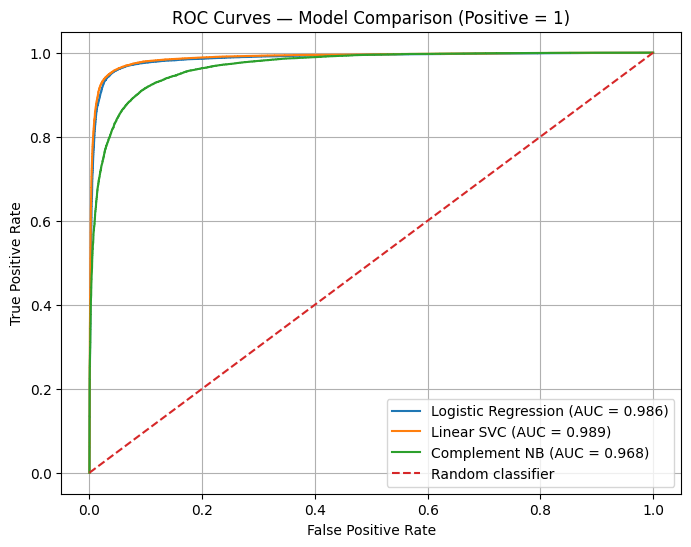

In [166]:

models = {
    "Logistic Regression": best_lr,
    "Linear SVC": best_svc,
    "Complement NB": best_nb
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # get a continuous score for ROC:
    # - LogReg: predict_proba
    # - NB: predict_proba
    # - LinearSVC: decision_function
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# diagonal baseline
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")

plt.title("ROC Curves — Model Comparison (Positive = 1)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### Supervised sentiment summary
To meet the supervised requirement, we trained and tuned supervised models on tweet text represented by TF-IDF features.

Because the dataset does not contain manual sentiment labels, we used **weak supervision**:
- we assigned labels only to **high-confidence** VADER cases (strongly positive / strongly negative),
- this creates a large training set while acknowledging that labels contain noise.

Models trained and compared (with hyperparameter tuning via cross-validation):
- TF-IDF + Logistic Regression
- TF-IDF + LinearSVC
- TF-IDF + Complement Naive Bayes

The best-performing model (LinearSVC) is then applied to score the full dataset, producing:
- `sent_sup_label`, `sent_sup_score`, and derived sentiment classes used in joint analysis.

#### Applying best model to asses every tweet in the dataset

In [42]:
best_model = best_svc  # tuned LinearSVC

df_sa["sent_sup_label"] = best_model.predict(df_sa["text_clean"].astype(str).fillna("").str.strip())
df_sa["sent_sup_score"] = best_model.decision_function(df_sa["text_clean"].astype(str).fillna("").str.strip())

df_sa["sent_sup_class"] = df_sa["sent_sup_label"].map({0: "negative", 1: "positive"})
df_sa[["sent_sup_class", "sent_sup_score"]].head()

,sent_sup_class,sent_sup_score
0,positive,0.322940
1,positive,0.393039
2,positive,0.024223
3,positive,0.369098
4,negative,-0.877655


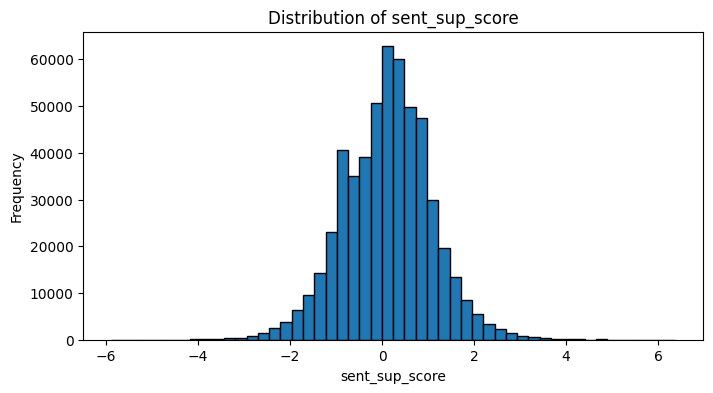

In [161]:

plt.figure(figsize=(8, 4))
plt.hist(df_sa["sent_sup_score"], bins=50, edgecolor="black")
plt.title("Distribution of sent_sup_score")
plt.xlabel("sent_sup_score")
plt.ylabel("Frequency")
plt.show()

#### Comparing our model vs VADER scores

In [92]:
t_neu = 0.375  # manually tested numerous options
df_sa["sent_sup_3class"] = np.where(
    df_sa["sent_sup_score"] >= t_neu, "positive",
    np.where(df_sa["sent_sup_score"] <= -t_neu, "negative", "neutral")
)

In [93]:
from sklearn.metrics import classification_report, confusion_matrix

# align label order
labels_3 = ["negative", "neutral", "positive"]

df_cmp3 = df_sa.dropna(subset=["sentiment", "sent_sup_3class"]).copy()
df_cmp3 = df_cmp3[df_cmp3["sentiment"].isin(labels_3)].copy()

print("Confusion matrix (rows=VADER, cols=SUP):")
print(pd.DataFrame(
    confusion_matrix(df_cmp3["sentiment"], df_cmp3["sent_sup_3class"], labels=labels_3),
    index=[f"VADER_{l}" for l in labels_3],
    columns=[f"SUP_{l}" for l in labels_3]
))

print("\nClassification report (SUP vs VADER as reference):")
print(classification_report(df_cmp3["sentiment"], df_cmp3["sent_sup_3class"], labels=labels_3, digits=4))

Confusion matrix (rows=VADER, cols=SUP):
                SUP_negative  SUP_neutral  SUP_positive
VADER_negative        144386        57725          9623
VADER_neutral           5196        65872         31636
VADER_positive          6945        45386        167575

Classification report (SUP vs VADER as reference):
              precision    recall  f1-score   support

    negative     0.9224    0.6819    0.7842    211734
     neutral     0.3898    0.6414    0.4849    102704
    positive     0.8024    0.7620    0.7817    219906

    accuracy                         0.7071    534344
   macro avg     0.7049    0.6951    0.6836    534344
weighted avg     0.7707    0.7071    0.7256    534344



**Important:** The comparison “Supervised vs VADER” measures **agreement between two methods**, not true accuracy (no human ground truth labels).  
It is used as a sanity check and to understand where models disagree (especially around neutral cases).

## Sentiment x Topic joint analysis

#### First, mapping topics manually

In [119]:
topic_name_map = {
    0: "Elections results/day",
    1: "Voting",
    2: "General commentary",
    3: "Joe Biden",
    4: "President/USA",
    5: "MAGA",
    6: "COVID-19",          
    7: "White House"
}

# add a new column with readable names (fallback to "Topic {id}" if missing)
df_sa["topic_name"] = df_sa["topic_id"].map(topic_name_map).fillna(
    df_sa["topic_id"].apply(lambda x: f"Topic {x}")
)

df_sa[["topic_id", "topic_name"]].drop_duplicates().sort_values("topic_id")

,topic_id,topic_name
6,0,Elections results/day
25,1,Voting
0,2,General commentary
16,3,Joe Biden
4,4,President/USA
7,5,MAGA
14,6,COVID-19
3,7,White House


In [124]:
df_sa

,tweet_id,created_at,tweet,country,retweet_count,likes,user_id,user_followers_count,text_clean,n_chars,...,compound,pos,neu,neg,sentiment,sent_sup_label,sent_sup_score,sent_sup_class,sent_sup_3class,topic_name
0,1.316529e+18,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years,...",United States of America,1.0,2.0,8.436472e+06,1185.0,trump as a student i used to hear for years fo...,237,...,0.5905,0.066,0.934,0.000,positive,1,0.322940,positive,neutral,General commentary
1,1.316529e+18,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he...,NaN,0.0,0.0,8.283556e+17,32.0,hours since last tweet from trump maybe he is ...,73,...,0.0000,0.000,1.000,0.000,neutral,1,0.393039,positive,positive,General commentary
2,1.316529e+18,2020-10-15 00:00:17,@CLady62 Her 15 minutes were over long time ag...,United States of America,0.0,2.0,1.138416e+09,2363.0,her minutes were over long time ago omarosa ne...,129,...,-0.4912,0.000,0.878,0.122,negative,1,0.024223,positive,neutral,General commentary
3,1.316529e+18,2020-10-15 00:00:17,@richardmarx Glad u got out of the house! DICK...,NaN,0.0,0.0,7.674018e+17,75.0,glad u got out of the house dick trump,38,...,0.5962,0.217,0.783,0.000,positive,1,0.369098,positive,neutral,White House
4,1.316529e+18,2020-10-15 00:00:18,@DeeviousDenise @realDonaldTrump @nypost There...,United States of America,0.0,0.0,9.007611e+17,766.0,there won t be many of them unless you all hav...,216,...,-0.2617,0.056,0.866,0.078,negative,0,-0.877655,negative,negative,President/USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542317,1.325589e+18,2020-11-08 23:59:36,13 emails from #Trump and Trumpettes today. 20...,Chile,0.0,1.0,3.578492e+08,1190.0,emails from trump and trumpettes today sat doz...,250,...,0.7574,0.170,0.773,0.056,positive,1,0.419408,positive,positive,Elections results/day
542318,1.325589e+18,2020-11-08 23:59:38,Stop laying @CNN !\n#Paris and #London dont gi...,France,0.0,0.0,3.873620e+08,27.0,stop laying paris and london dont give a fuck ...,144,...,0.6290,0.163,0.744,0.092,positive,1,0.150192,positive,neutral,Joe Biden
542319,1.325589e+18,2020-11-08 23:59:42,earlier this week we got rid of #trump; today ...,NaN,0.0,7.0,1.416797e+09,50.0,earlier this week we got rid of trump today my...,132,...,-0.0240,0.097,0.803,0.100,neutral,1,0.358822,positive,neutral,General commentary
542320,1.325589e+18,2020-11-08 23:59:54,"@sammelbis1998 @iheartmindy @bnorthg First, yo...",NaN,0.0,0.0,7.687811e+08,1079.0,first you would need to compare that to previo...,250,...,-0.5574,0.000,0.930,0.070,negative,0,-0.355228,negative,neutral,Voting


#### Sentiment distribution withiin each topic

In [134]:
topic_sup_counts = pd.crosstab(df_sa["topic_id"], df_sa["sent_sup_3class"])

order = ["positive", "neutral", "negative"]
topic_sup_counts = topic_sup_counts.reindex(columns=order, fill_value=0)

topic_sent_pct = round(topic_sup_counts.div(topic_sup_counts.sum(axis=1), axis=0) * 100, 2)
topic_sent_pct = topic_sent_pct.add_suffix("_pct")

topic_sent_table = pd.concat([topic_sup_counts, topic_sent_pct], axis=1)

topic_sent_table

sent_sup_3class,positive,neutral,negative,positive_pct,neutral_pct,negative_pct
topic_id,,,,,,
0,17803,13820,11003,41.77,32.42,25.81
1,17578,13322,10429,42.53,32.23,25.23
2,94719,80794,82680,36.69,31.29,32.02
3,36547,24829,14891,47.92,32.56,19.52
4,18351,11588,9306,46.76,29.53,23.71
5,11578,8393,6520,43.71,31.68,24.61
6,7455,12069,17843,19.95,32.30,47.75
7,4803,4168,3855,37.45,32.50,30.06


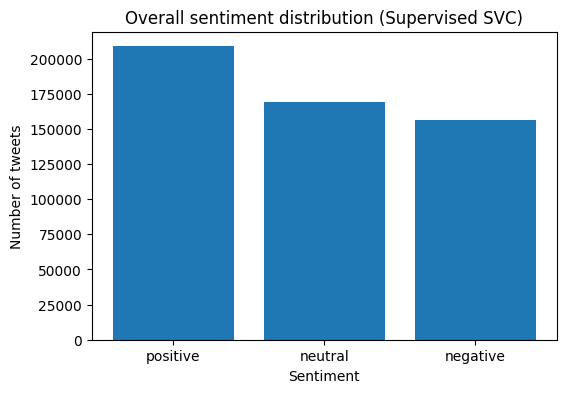

In [135]:

import matplotlib.pyplot as plt

sent_counts = df_sa["sent_sup_3class"].value_counts().reindex(["positive","neutral","negative"])

plt.figure(figsize=(6,4))
plt.bar(sent_counts.index, sent_counts.values)
plt.title("Overall sentiment distribution (Supervised SVC)")
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.show()

#### Heatmap of sentiment for topics

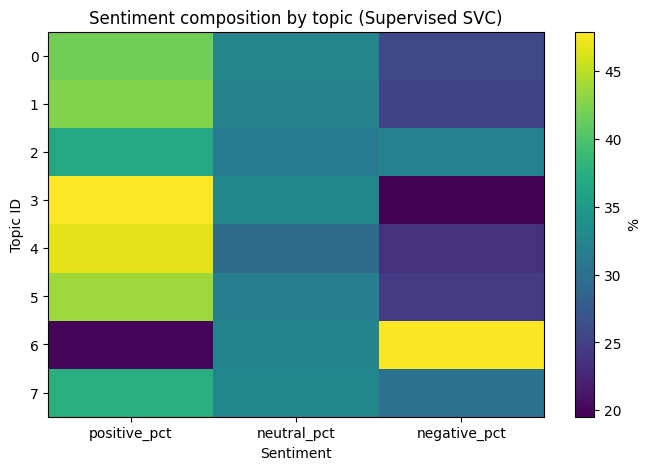

In [136]:
plt.figure(figsize=(8,5))
plt.imshow(topic_sent_pct.values, aspect="auto")
plt.title("Sentiment composition by topic (Supervised SVC)")
plt.xlabel("Sentiment")
plt.ylabel("Topic ID")
plt.xticks(range(len(topic_sent_pct.columns)), topic_sent_pct.columns)
plt.yticks(range(len(topic_sent_pct.index)), topic_sent_pct.index)
plt.colorbar(label="%")
plt.show()

#### Mean sentiment per topic

In [137]:
topic_scores = (
    df_sa.groupby("topic_name")
         .agg(
             n=("tweet_id", "count"),
             mean_score=("sent_sup_score", "mean"),
             median_score=("sent_sup_score", "median"),
             pos_rate=("sent_sup_3class", lambda x: (x=="positive").mean()),
             neu_rate=("sent_sup_3class", lambda x: (x=="neutral").mean()),
             neg_rate=("sent_sup_3class", lambda x: (x=="negative").mean()),
         )
         .sort_values("mean_score", ascending=False)
)

topic_scores.head(10)

,n,mean_score,median_score,pos_rate,neu_rate,neg_rate
topic_name,,,,,,
Joe Biden,76267,0.336296,0.337076,0.479198,0.325554,0.195248
President/USA,39245,0.295386,0.305907,0.467601,0.295273,0.237126
MAGA,26491,0.217719,0.253462,0.437054,0.316825,0.246121
Elections results/day,42626,0.189527,0.216269,0.417656,0.324215,0.258129
Voting,41329,0.184654,0.232596,0.425319,0.322340,0.252341
General commentary,258193,0.049350,0.088454,0.366853,0.312921,0.320226
White House,12826,0.048387,0.137582,0.374474,0.324965,0.300561
COVID-19,37367,-0.370531,-0.319943,0.199508,0.322986,0.477507


clip lo/hi: -2.269408694529716 2.4765726208060492
max abs after clip: 2.4765726208060492


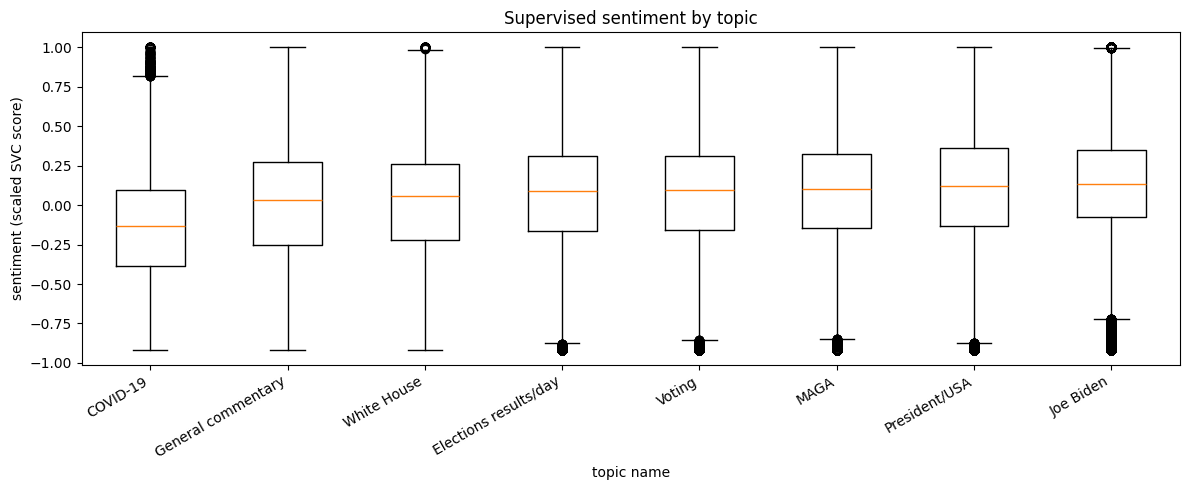

In [165]:
sent_col = "sent_sup_score"

# robust clip by quantiles (adjust if needed)
LOW_Q, HIGH_Q = 0.01, 0.99
lo, hi = np.quantile(df_sa[sent_col].dropna().values, [LOW_Q, HIGH_Q])

df_sa["sent_sup_score_clip"] = df_sa[sent_col].clip(lo, hi)

# rescale clipped values to [-1, 1]
mx = np.max(np.abs(df_sa["sent_sup_score_clip"].values))
df_sa["sent_sup_score_scaled"] = df_sa["sent_sup_score_clip"] / mx

print("clip lo/hi:", lo, hi)
print("max abs after clip:", mx)
df_sa[["sent_sup_score", "sent_sup_score_clip", "sent_sup_score_scaled"]].head()

plot_col = "sent_sup_score_scaled"

topic_order = (
    df_sa.groupby("topic_name")[plot_col]
        .median()
        .sort_values(ascending=True)
        .index
        .tolist()
)

data = [df_sa.loc[df_sa["topic_name"] == t, plot_col].dropna().values for t in topic_order]

plt.figure(figsize=(12, 5))
plt.boxplot(data, labels=topic_order, showfliers=True)
plt.title("Supervised sentiment by topic")
plt.xlabel("topic name")
plt.ylabel("sentiment (scaled SVC score)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

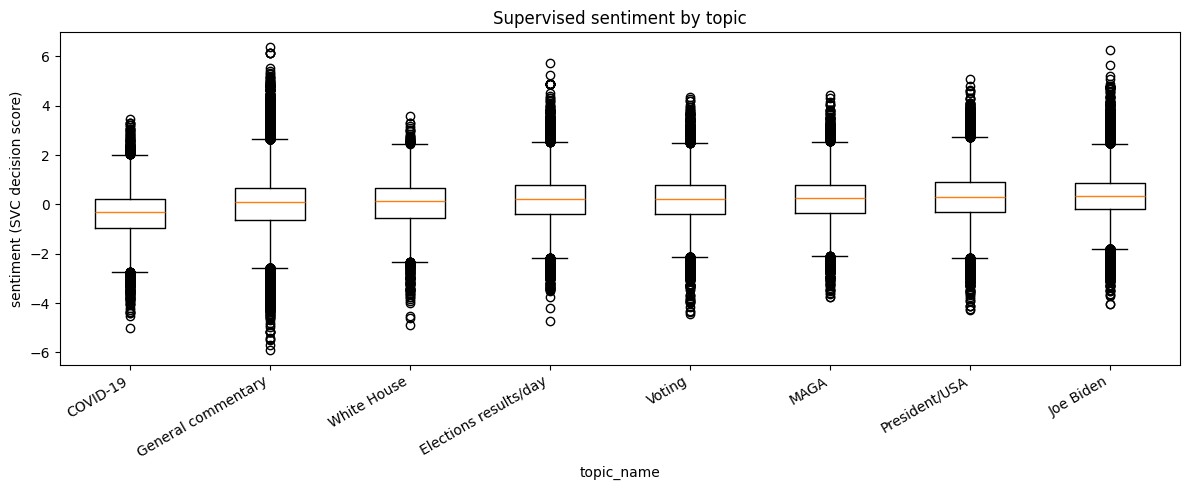

In [155]:
# ============================================================
# BOXPLOT: SUPERVISED sentiment by topic_name
# Uses: sent_sup_score (LinearSVC decision_function)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

sent_col = "sent_sup_score"  # supervised score (unbounded, centered ~0)

# ensure topic_name exists
if "topic_name" not in df_sa.columns:
    df_sa["topic_name"] = df_sa["topic_id"].apply(lambda x: f"Topic {x}")

# optional: order topics by median supervised score (nice readability)
topic_order = (
    df_sa.groupby("topic_name")[sent_col]
        .median()
        .sort_values(ascending=True)
        .index
        .tolist()
)

# build data arrays for matplotlib
data = [df_sa.loc[df_sa["topic_name"] == t, sent_col].dropna().values for t in topic_order]

plt.figure(figsize=(12, 5))
plt.boxplot(data, labels=topic_order, showfliers=True)
plt.title("Supervised sentiment by topic")
plt.xlabel("topic_name")
plt.ylabel("sentiment (SVC decision score)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## Final summary


### What was achieved
- Extracted interpretable topics from Trump-related tweets using TF-IDF + NMF.
- Measured sentiment using two approaches:
  - VADER as a lexicon baseline,
  - a tuned supervised classifier (best: LinearSVC) trained via weak supervision.
- Combined topics and sentiment to identify which themes are associated with more positive/negative tone.


### Key results
- Number of topics: 8
- Overall supervised sentiment distribution: …% negative / …% neutral / …% positive
- Most negative topics (by mean supervised score): Topic 6 - COVID-19, Topic 2 - General commentary
- Most positive topics (by mean supervised score): Topic X - Joe Biden, Topic Y - President/USA



### Main limitations
- Weak supervision: supervised model is trained using high-confidence VADER labels, not human ground truth.
- Sentiment in political tweets is noisy (sarcasm, irony, coded language).
- Topic model evaluation is primarily interpretability-based; topic stability across K is not deeply tested.



### Next steps (optional)
- Add a small manual annotation sample (e.g., 300–500 tweets) to validate supervised performance.
- Run a short K-sweep (e.g., 6/8/10/12) and compare topic redundancy/coherence qualitatively.
- Compare topic–sentiment patterns over time (weekly/monthly trends).